# Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0-preview is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Vanishing/Exploding Gradients Problem

In [2]:
def logit(z):
    return 1 / (1 + np.exp(-z))

Saving figure sigmoid_saturation_plot


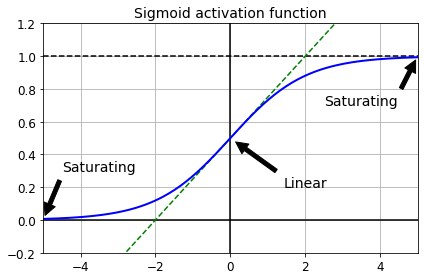

In [3]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("sigmoid_saturation_plot")
plt.show()

# Xavier and He Initialization

In [4]:
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'Identity',
 'Initializer',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'serialize',
 'zeros']

In [5]:
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

In [6]:
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                          distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=init)

## Nonsaturating Activation Functions

### Leaky ReLU

In [7]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

Saving figure leaky_relu_plot


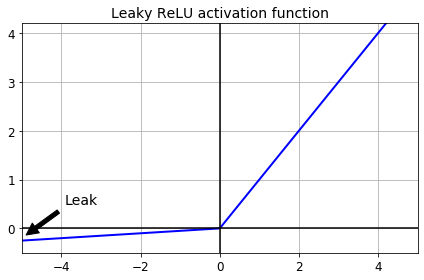

In [8]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

In [9]:
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'tanh']

In [10]:
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

Let's train a neural network on Fashion MNIST using the Leaky ReLU:

In [11]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [12]:
X_train.shape

(55000, 28, 28)

In [13]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]), # flatten to (55000, 784)
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [14]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [15]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 3s 61us/sample - loss: 1.2806 - accuracy: 0.6250 - val_loss: 0.8883 - val_accuracy: 0.7152
Epoch 2/10
55000/55000 [==============================] - 3s 54us/sample - loss: 0.7954 - accuracy: 0.7373 - val_loss: 0.7135 - val_accuracy: 0.764860 
Epoch 3/10
55000/55000 [==============================] - 3s 56us/sample - loss: 0.6816 - accuracy: 0.7727 - val_loss: 0.6356 - val_accuracy: 0.7882
Epoch 4/10
55000/55000 [==============================] - 3s 60us/sample - loss: 0.6215 - accuracy: 0.7935 - val_loss: 0.5922 - val_accuracy: 0.8012
Epoch 5/10
55000/55000 [==============================] - 3s 59us/sample - loss: 0.5830 - accuracy: 0.8081 - val_loss: 0.5596 - val_accuracy: 0.8172
Epoch 6/10
55000/55000 [==============================] - 3s 50us/sample - loss: 0.5553 - accuracy: 0.8155 - val_loss: 0.5338 - val_accuracy: 0.8240
Epoch 7/10
55000/55000 [==============================

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 300)               235500    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 300)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               30100     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
__________________________________________________

### PReLU

Now let's try Parametric Rectified Linear Unit:

In [17]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [18]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [19]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [20]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 3s 61us/sample - loss: 1.3470 - accuracy: 0.6225 - val_loss: 0.9268 - val_accuracy: 0.7200
Epoch 2/10
55000/55000 [==============================] - 3s 53us/sample - loss: 0.8208 - accuracy: 0.7357 - val_loss: 0.7322 - val_accuracy: 0.7640
Epoch 3/10
55000/55000 [==============================] - 3s 54us/sample - loss: 0.6972 - accuracy: 0.7697 - val_loss: 0.6494 - val_accuracy: 0.7868
Epoch 4/10
55000/55000 [==============================] - 3s 54us/sample - loss: 0.6332 - accuracy: 0.7904 - val_loss: 0.6027 - val_accuracy: 0.8024
Epoch 5/10
55000/55000 [==============================] - 3s 53us/sample - loss: 0.5918 - accuracy: 0.8051 - val_loss: 0.5674 - val_accuracy: 0.8140
Epoch 6/10
55000/55000 [==============================] - 3s 60us/sample - loss: 0.5619 - accuracy: 0.8140 - val_loss: 0.5393 - val_accuracy: 0.8252
Epoch 7/10
55000/55000 [==============================] -

In [21]:
# keras.utils.plot_model(model, "my_mnist_model.png", show_shapes=True)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 300)               235500    
_________________________________________________________________
p_re_lu_2 (PReLU)            (None, 300)               300       
_________________________________________________________________
dense_9 (Dense)              (None, 100)               30100     
_________________________________________________________________
p_re_lu_3 (PReLU)            (None, 100)               100       
_________________________________________________________________
dense_10 (Dense)             (None, 10)                1010      
Total params: 267,010
Trainable params: 267,010
Non-trainable params: 0
________________________________________________

### ELU
Let's play Exponential Linear Unit:

In [22]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

Saving figure elu_plot


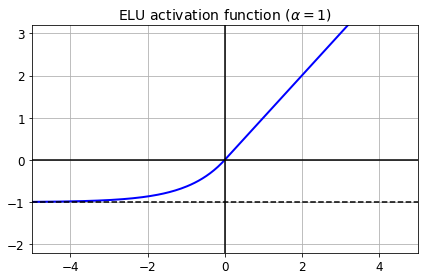

In [23]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("elu_plot")
plt.show()

Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer:

In [24]:
keras.layers.Dense(10, activation="elu")

### SELU

This activation function was proposed in this [great paper](https://arxiv.org/pdf/1706.02515.pdf) by Günter Klambauer, Thomas Unterthiner and Andreas Mayr, published in June 2017. During training, a neural network composed exclusively of a stack of __dense layers__ using the __SELU activation__ function and __LeCun initialization__ will __self-normalize__: 

### requirement: __standardized inputs, sequential model, dense layers, LeCun initialization__ 

>the output of each layer will tend to preserve the same mean and variance during training, 

which solves the vanishing/exploding gradients problem. As a result, this activation function outperforms the other activation functions very significantly for such neural nets, so you should really try it out. 

Unfortunately, the self-normalizing property of the SELU activation function is easily broken: you cannot use ℓ<sub>1</sub> or ℓ<sub>2</sub> regularization, regular dropout, max-norm, skip connections or other non-sequential topologies (so recurrent neural networks won't self-normalize). However, in practice it works quite well with sequential CNNs. If you break self-normalization, SELU will not necessarily outperform other activation functions.

In [25]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (
            (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) 
            * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2  
            + np.pi*erfc(1/np.sqrt(2))**2*np.e 
            - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)
            )

In [26]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

Saving figure selu_plot


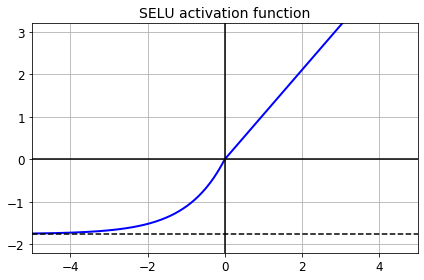

In [27]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("selu_plot")
plt.show()

By default, the SELU hyperparameters (`scale` and `alpha`) are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too). Using this activation function, even a 1,000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

In [28]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # standardized inputs
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun initialization
    Z = selu(Z@W)
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


Using SELU is easy:

In [29]:
keras.layers.Dense(10, activation="selu",
                   kernel_initializer="lecun_normal")

Let's create a neural net for Fashion MNIST with 100 hidden layers, using the SELU activation function:

In [30]:
np.random.seed(42)
tf.random.set_seed(42)

In [31]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [32]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation 1:

In [33]:
X_train.shape

(55000, 28, 28)

In [34]:
# don't forget keepdims
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [35]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 34s 612us/sample - loss: 1.3654 - accuracy: 0.4650 - val_loss: 1.3350 - val_accuracy: 0.4226
Epoch 2/5
55000/55000 [==============================] - 26s 478us/sample - loss: 1.0764 - accuracy: 0.5620 - val_loss: 0.8297 - val_accuracy: 0.6720
Epoch 3/5
55000/55000 [==============================] - 25s 456us/sample - loss: 0.7583 - accuracy: 0.7122 - val_loss: 0.6718 - val_accuracy: 0.7572
Epoch 4/5
55000/55000 [==============================] - 25s 452us/sample - loss: 0.6541 - accuracy: 0.7585 - val_loss: 0.6227 - val_accuracy: 0.7784
Epoch 5/5
55000/55000 [==============================] - 25s 459us/sample - loss: 0.6078 - accuracy: 0.7786 - val_loss: 0.5928 - val_accuracy: 0.7966


Now look at what happens if we try to use the ReLU activation function instead:

In [36]:
np.random.seed(42)
tf.random.set_seed(42)

In [37]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu", # now "ReLu"
                             kernel_initializer="he_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="relu", 
                                 kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [38]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [39]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 19s 338us/sample - loss: 1.8183 - accuracy: 0.2622 - val_loss: 1.2275 - val_accuracy: 0.4776
Epoch 2/5
55000/55000 [==============================] - 14s 259us/sample - loss: 1.1048 - accuracy: 0.5380 - val_loss: 0.9821 - val_accuracy: 0.5538
Epoch 3/5
55000/55000 [==============================] - 14s 256us/sample - loss: 0.9367 - accuracy: 0.6199 - val_loss: 0.8287 - val_accuracy: 0.6860
Epoch 4/5
55000/55000 [==============================] - 14s 254us/sample - loss: 0.7906 - accuracy: 0.6868 - val_loss: 0.7166 - val_accuracy: 0.7484
Epoch 5/5
55000/55000 [==============================] - 14s 254us/sample - loss: 0.6905 - accuracy: 0.7417 - val_loss: 0.6236 - val_accuracy: 0.7564


```python
[selu] 
Epoch 5/5
55000/55000 [==============================] - 52s 943us/sample - loss: 0.6078 - accuracy: 0.7786 - val_loss: 0.5928 - val_accuracy: 0.7966
[relu]
55000/55000 [==============================] - 30s 542us/sample - loss: 0.6905 - accuracy: 0.7417 - val_loss: 0.6236 - val_accuracy: 0.7564
```

Not great at all, we suffered from the vanishing/exploding gradients problem.

# Batch Normalization

Although using He initialization along with ELU (or any variant of ReLU) can significantly reduce the vanishing/exploding gradients problems at the beginning of training, it doesn’t guarantee that they won’t come back during training.

`Batch Normalization (BN)` consists of adding an operation in the model just before or after the activation function of each hidden layer, simply zero-centering and normalizing each input, then scaling and shifting the result using two new parameter vectors per layer: one for scaling, the other for shifting. In other words, this operation lets the model learn the optimal scale and mean of each of the layer’s inputs. In many cases, if you add a BN layer as the very first layer of your neural network, you do not need to standardize your training set.

`Note`: 1 unit in the previous layer requires 4 parameters for batch normalization.

In [40]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [41]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense_215 (Dense)            (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_216 (Dense)            (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_217 (Dense)            (None, 10)               

In [42]:
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

gamma is the output scale parameter vector for the layer and beta is the output shift (offset) parameter vector for the layer.

In [43]:
bn1.updates

[<tf.Operation 'cond/Identity' type=Identity>,
 <tf.Operation 'cond_1/Identity' type=Identity>]

In [44]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [45]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 5s 96us/sample - loss: 0.8767 - accuracy: 0.7137 - val_loss: 0.5532 - val_accuracy: 0.8208
Epoch 2/10
55000/55000 [==============================] - 4s 75us/sample - loss: 0.5755 - accuracy: 0.8018 - val_loss: 0.4759 - val_accuracy: 0.8458
Epoch 3/10
55000/55000 [==============================] - 4s 74us/sample - loss: 0.5154 - accuracy: 0.8212 - val_loss: 0.4395 - val_accuracy: 0.8542
Epoch 4/10
55000/55000 [==============================] - 4s 76us/sample - loss: 0.4842 - accuracy: 0.8312 - val_loss: 0.4161 - val_accuracy: 0.8594
Epoch 5/10
55000/55000 [==============================] - 4s 77us/sample - loss: 0.4561 - accuracy: 0.8424 - val_loss: 0.4003 - val_accuracy: 0.8644
Epoch 6/10
55000/55000 [==============================] - 4s 74us/sample - loss: 0.4400 - accuracy: 0.8468 - val_loss: 0.3884 - val_accuracy: 0.8702
Epoch 7/10
55000/55000 [==============================] -

Sometimes applying BN before the activation function works better (there's a debate on this topic). Moreover, the layer before a `BatchNormalization` layer __does not need to have bias terms__, since the `BatchNormalization` layer some as well, it would be a waste of parameters, so you can set `use_bias=False` when creating those layers:

In [46]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False), 
    keras.layers.BatchNormalization(), # now notice that it's before activation function
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.Activation("relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [47]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 784)               3136      
_________________________________________________________________
dense_218 (Dense)            (None, 300)               235200    
_________________________________________________________________
batch_normalization_4 (Batch (None, 300)               1200      
_________________________________________________________________
activation (Activation)      (None, 300)               0         
_________________________________________________________________
dense_219 (Dense)            (None, 100)               30000     
_________________________________________________________________
activation_1 (Activation)    (None, 100)              

In [48]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [49]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 5s 96us/sample - loss: 0.8632 - accuracy: 0.7101 - val_loss: 0.5635 - val_accuracy: 0.8104
Epoch 2/10
55000/55000 [==============================] - 5s 83us/sample - loss: 0.5795 - accuracy: 0.8012 - val_loss: 0.4848 - val_accuracy: 0.8374
Epoch 3/10
55000/55000 [==============================] - 4s 81us/sample - loss: 0.5188 - accuracy: 0.8217 - val_loss: 0.4480 - val_accuracy: 0.8470
Epoch 4/10
55000/55000 [==============================] - 5s 84us/sample - loss: 0.4832 - accuracy: 0.8309 - val_loss: 0.4253 - val_accuracy: 0.8550
Epoch 5/10
55000/55000 [==============================] - 5s 90us/sample - loss: 0.4588 - accuracy: 0.8399 - val_loss: 0.4093 - val_accuracy: 0.8602
Epoch 6/10
55000/55000 [==============================] - 5s 96us/sample - loss: 0.4398 - accuracy: 0.8475 - val_loss: 0.3983 - val_accuracy: 0.8628
Epoch 7/10
55000/55000 [==============================] -

In [50]:
model.predict(X_test_scaled[:5])

array([[1.0891242e-18, 6.4668331e-15, 1.4509570e-19, 7.4868200e-15,
        1.4285656e-19, 9.9861872e-01, 5.8086532e-22, 6.5719208e-10,
        1.6701212e-15, 1.3812929e-03],
       [1.6223912e-13, 4.2282824e-14, 1.0000000e+00, 4.7137431e-14,
        5.2299765e-09, 5.3410325e-11, 1.4546795e-09, 3.6435177e-15,
        1.7946608e-15, 2.1117806e-12],
       [1.1400070e-16, 1.0000000e+00, 2.8676460e-19, 1.9894204e-15,
        1.8474077e-14, 1.2614805e-12, 4.9713220e-18, 6.9929146e-21,
        2.4329714e-17, 1.6451126e-18],
       [7.7966198e-18, 1.0000000e+00, 5.6248251e-19, 3.0500550e-12,
        1.0615453e-17, 4.7535760e-11, 5.3458026e-22, 1.1114442e-21,
        2.1668764e-19, 2.3247770e-15],
       [7.0678572e-05, 1.0373458e-09, 5.7475955e-07, 3.0852661e-05,
        1.7740500e-06, 2.4537288e-04, 9.9965024e-01, 7.7310008e-10,
        2.3520850e-11, 4.1947251e-07]], dtype=float32)

In [51]:
model.predict(X_test_scaled[:5], batch_size=1)

array([[1.0891200e-18, 6.4668081e-15, 1.4509460e-19, 7.4868200e-15,
        1.4285602e-19, 9.9861872e-01, 5.8086088e-22, 6.5718958e-10,
        1.6701148e-15, 1.3812771e-03],
       [1.6223943e-13, 4.2282906e-14, 1.0000000e+00, 4.7137611e-14,
        5.2299960e-09, 5.3410731e-11, 1.4546850e-09, 3.6435457e-15,
        1.7946676e-15, 2.1117847e-12],
       [1.1400113e-16, 1.0000000e+00, 2.8676679e-19, 1.9894280e-15,
        1.8474182e-14, 1.2614878e-12, 4.9713030e-18, 6.9929413e-21,
        2.4329809e-17, 1.6451189e-18],
       [7.7966198e-18, 1.0000000e+00, 5.6248251e-19, 3.0500491e-12,
        1.0615412e-17, 4.7535760e-11, 5.3457622e-22, 1.1114399e-21,
        2.1668764e-19, 2.3247592e-15],
       [7.0678703e-05, 1.0373458e-09, 5.7476120e-07, 3.0852632e-05,
        1.7740500e-06, 2.4537335e-04, 9.9965024e-01, 7.7310303e-10,
        2.3520895e-11, 4.1947371e-07]], dtype=float32)

In [52]:
np.isclose(model.predict(X_test_scaled[:5]), 
           model.predict(X_test_scaled[:5], batch_size=1)).all()

True

## Gradient Clipping

All Keras optimizers accept `clipnorm` or `clipvalue` arguments:

In [53]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)

This will clip every component of the gradient vector to a value between –1.0 and 1.0.

In [54]:
optimizer = keras.optimizers.SGD(clipnorm=1.0)

If you want to ensure that `Gradient Clipping` does not change the direction of the gradient vector, you should clip by `norm` by setting `clipnorm` instead of `clipvalue`. This will clip the whole gradient if its $\ell_2$ norm is greater than the threshold you picked.

## Reusing Pretrained Layers
It is generally not a good idea to train a very large DNN from scratch: instead, you should always try to find an existing neural network that accomplishes a similar task to the one you are trying to tackle then just reuse the lower layers of this network: this is called `transfer learning`.

### Reusing a Keras model

Let's split the fashion MNIST training set in two:
* `X_train_A`: all images of all items except for sandals and shirts (classes 5 and 6).
* `X_train_B`: a much smaller training set of just the first 200 images of sandals or shirts.

The validation set and the test set are also split this way, but without restricting the number of images.

We will __train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification)__. We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (sneakers, ankle boots, coats, t-shirts, etc.) are somewhat similar to classes in set B (sandals and shirts). However, since we are using `Dense` layers, only patterns that occur at the same location can be reused (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image, as we will see in the CNN chapter).

In [55]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [56]:
X_train_A.shape

(43986, 28, 28)

In [57]:
X_train_B.shape

(200, 28, 28)

In [58]:
y_train_A[:30]

array([4, 0, 5, 7, 7, 7, 4, 4, 3, 4, 0, 1, 6, 3, 4, 3, 2, 6, 5, 3, 4, 5,
       1, 3, 4, 2, 0, 6, 7, 1], dtype=uint8)

In [59]:
np.unique(y_train_A)

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=uint8)

In [60]:
y_train_B[:30]

array([1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.], dtype=float32)

In [61]:
np.unique(y_train_B)

array([0., 1.], dtype=float32)

In [62]:
tf.random.set_seed(42)
np.random.seed(42)

In [63]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [64]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

In [65]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Train on 43986 samples, validate on 4014 samples
Epoch 1/20
43986/43986 [==============================] - 5s 111us/sample - loss: 0.5909 - accuracy: 0.8100 - val_loss: 0.3772 - val_accuracy: 0.8712
Epoch 2/20
43986/43986 [==============================] - 4s 90us/sample - loss: 0.3520 - accuracy: 0.8793 - val_loss: 0.3393 - val_accuracy: 0.8782
Epoch 3/20
43986/43986 [==============================] - 4s 90us/sample - loss: 0.3167 - accuracy: 0.8889 - val_loss: 0.3016 - val_accuracy: 0.8961
Epoch 4/20
43986/43986 [==============================] - 4s 94us/sample - loss: 0.2969 - accuracy: 0.8967 - val_loss: 0.2858 - val_accuracy: 0.9031
Epoch 5/20
43986/43986 [==============================] - 4s 88us/sample - loss: 0.2824 - accuracy: 0.9032 - val_loss: 0.2807 - val_accuracy: 0.9063
Epoch 6/20
43986/43986 [==============================] - 4s 82us/sample - loss: 0.2721 - accuracy: 0.9071 - val_loss: 0.2683 - val_accuracy: 0.9103
Epoch 7/20
43986/43986 [==============================] 

Keras model on this set and got reasonably good performance (>90% accuracy).

In [66]:
model_A.save("my_model_A.h5")

Let's train on (X_train_B, y_train_B) without transfer.

In [67]:
# Same architecture as model A
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

In [68]:
model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

In [69]:
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Train on 200 samples, validate on 986 samples
Epoch 1/20
200/200 [==============================] - 1s 6ms/sample - loss: 0.9545 - accuracy: 0.4600 - val_loss: 0.6655 - val_accuracy: 0.5385
Epoch 2/20
200/200 [==============================] - 0s 453us/sample - loss: 0.5899 - accuracy: 0.6900 - val_loss: 0.4785 - val_accuracy: 0.8519
Epoch 3/20
200/200 [==============================] - 0s 449us/sample - loss: 0.4512 - accuracy: 0.8800 - val_loss: 0.4098 - val_accuracy: 0.8945
Epoch 4/20
200/200 [==============================] - 0s 450us/sample - loss: 0.3871 - accuracy: 0.9100 - val_loss: 0.3666 - val_accuracy: 0.9128
Epoch 5/20
200/200 [==============================] - 0s 444us/sample - loss: 0.3438 - accuracy: 0.9250 - val_loss: 0.3315 - val_accuracy: 0.9300
Epoch 6/20
200/200 [==============================] - 0s 452us/sample - loss: 0.3095 - accuracy: 0.9300 - val_loss: 0.3034 - val_accuracy: 0.9402
Epoch 7/20
200/200 [==============================] - 0s 443us/sample - loss: 0.

With the same architecture as model A, it performs reasonably well (97% accuracy), but since it’s a much easier task (there are just 2 classes), you were hoping for more.

Now let's do transfer learning

![figure11-4](https://github.com/soo-pecialist/Hands_on_ML_w_Scikit_Karas_and_TensorFlow/blob/master/images_used/figure11_4.png?raw=true)

In [70]:
model_A = keras.models.load_model("my_model_A.h5")
# drop softmax (output) layer
model_B_on_A = keras.models.Sequential(model_A.layers[:-1]) 
# instead, add sigmoid activation.
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid")) 

Note that `model_A` and `model_B_on_A` now share some layers. When you train `model_B_on_A`, it will also __affect__ `model_A`. If you want to avoid that, you need to __clone__ `model_A` before you reuse its layers.

In [71]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

Freeze the reused layers during the first few epochs, giving the new output layer some time to learn reasonable weights. 

In [72]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False # freeze weights in these layers

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])

history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

Train on 200 samples, validate on 986 samples
Epoch 1/4
200/200 [==============================] - 1s 5ms/sample - loss: 0.5807 - accuracy: 0.6550 - val_loss: 0.5813 - val_accuracy: 0.6450
Epoch 2/4
200/200 [==============================] - 0s 372us/sample - loss: 0.5425 - accuracy: 0.7050 - val_loss: 0.5468 - val_accuracy: 0.6815
Epoch 3/4
200/200 [==============================] - 0s 373us/sample - loss: 0.5086 - accuracy: 0.7200 - val_loss: 0.5164 - val_accuracy: 0.7140
Epoch 4/4
200/200 [==============================] - 0s 378us/sample - loss: 0.4784 - accuracy: 0.7600 - val_loss: 0.4870 - val_accuracy: 0.7292


> `Note`: You must always compile your model after you freeze or unfreeze layers.

Now, unfreeze the reused layers (which requires compiling the model again) and continue training to fine-tune the reused layers for task B. After unfreezing the reused layers, it is usually a good idea to reduce the learning rate, once again to avoid damaging the reused weights. However, in this example, we do not alter the learning rate:

In [73]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True # unfreeze

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])

# train more times
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Train on 200 samples, validate on 986 samples
Epoch 1/16
200/200 [==============================] - 1s 4ms/sample - loss: 0.3964 - accuracy: 0.8200 - val_loss: 0.3384 - val_accuracy: 0.8722
Epoch 2/16
200/200 [==============================] - 0s 402us/sample - loss: 0.2752 - accuracy: 0.9300 - val_loss: 0.2612 - val_accuracy: 0.9260
Epoch 3/16
200/200 [==============================] - 0s 409us/sample - loss: 0.2108 - accuracy: 0.9650 - val_loss: 0.2152 - val_accuracy: 0.9523
Epoch 4/16
200/200 [==============================] - 0s 403us/sample - loss: 0.1711 - accuracy: 0.9750 - val_loss: 0.1805 - val_accuracy: 0.9635
Epoch 5/16
200/200 [==============================] - 0s 402us/sample - loss: 0.1413 - accuracy: 0.9800 - val_loss: 0.1574 - val_accuracy: 0.9757
Epoch 6/16
200/200 [==============================] - 0s 398us/sample - loss: 0.1212 - accuracy: 0.9900 - val_loss: 0.1395 - val_accuracy: 0.9807
Epoch 7/16
200/200 [==============================] - 0s 390us/sample - loss: 0.

So, what's the final verdict?

In [74]:
model_B.evaluate(X_test_B, y_test_B, verbose=0)

[0.1444666212797165, 0.9695]

In [75]:
model_B_on_A.evaluate(X_test_B, y_test_B, verbose=0)

[0.06899205100536346, 0.9925]

Great! We got quite a bit of transfer: the error rate dropped by a factor of almost 4!

In [76]:
(100 - 96.95) / (100 - 99.25)

4.066666666666663

Don't get too excited yet! If you try to change the classes or the random seed, you will see that the improvement generally drops, or even vanishes or reverses. So take the effect with a grain of salt.

# Faster Optimizers

## Momentum optimization

Momentum optimization cares a great deal about what previous gradients were: at each iteration, it subtracts the local gradient from the momentum vector $m$ (multiplied by the learning rate $\eta$), and it updates the weights by simply adding this momentum vector.

$$
\begin{align}
m \leftarrow&  \beta m + (1-\beta) \nabla_{\theta}J(\theta) \\
\theta \leftarrow&  \theta - \eta m
\end{align}
$$

Typically, $\beta\ \approx 0.9$ and it is considered $\frac{1}{1-\beta}$ days (instances) moving average. 

In [77]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9)

## Nesterov Accelerated Gradient (NAG)

NAG measures the gradient of the cost function not at the local position but __slightly ahead in the direction__ of the momentum. The only difference from vanilla Momentum optimization is that the gradient is measured at $\theta + \beta m$ rather than at $\theta$.

$$
\begin{align}
m \leftarrow&  \beta m + (1-\beta) \nabla_{\theta}J(\theta + \beta m) \\
\theta \leftarrow&  \theta - \eta m
\end{align}
$$

This small tweak works because in general the momentum vector will be pointing in the right direction (i.e., toward the optimum), so it will be slightly more accurate to use the gradient measured a bit farther in that direction rather than using the gradient at the original position.

![Figure 11-6](https://github.com/soo-pecialist/Hands_on_ML_w_Scikit_Karas_and_TensorFlow/blob/master/images_used/figure11_6.png?raw=true)

In [78]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)

## AdaGrad
AdaGrad algorithm achieves going down the steepest slope by scaling down the gradient vector along the steepest dimensions. 

$$
\begin{align}
s \leftarrow&  s + \nabla_{\theta}J(\theta) \otimes \nabla_{\theta}J(\theta) \quad \otimes \text{is element-wise multiplication}\\
\theta \leftarrow&  \theta - \eta \nabla_{\theta}J(\theta) \oslash \sqrt{s + \epsilon} \quad \oslash \text{is element-wise division}
\end{align}
$$

In short, this algorithm decays the learning rate, but it does so faster for steep dimensions than for dimensions with gentler slopes. This is called an `adaptive learning rate`. It helps point the resulting updates more directly toward the global optimum.

![Figure 11-7](https://github.com/soo-pecialist/Hands_on_ML_w_Scikit_Karas_and_TensorFlow/blob/master/images_used/figure11_7.png?raw=true)

In [79]:
optimizer = keras.optimizers.Adagrad(lr=0.001)

`AdaGrad` often performs well for simple quadratic problems, but unfortunately it often stops too early when training neural networks. The learning rate gets scaled down so much that the algorithm ends up stopping entirely before reaching the global optimum. So even though Keras has an Adagrad optimizer, you __should not use it to train deep neural networks__

## RMSProp
Root Mean square propagation fixes AdaGrad problem by accumulating only the gradients form the most recent iterations (as opposed to all the gridents since the beginning of training).

$$
\begin{align}
s \leftarrow&  \rho s + (1-\rho)\nabla_{\theta}J(\theta) \otimes \nabla_{\theta}J(\theta) \\
\theta \leftarrow&  \theta - \eta \nabla_{\theta}J(\theta) \oslash \sqrt{s + \epsilon}
\end{align}
$$

Typically $\rho \approx 0.99$ or $0.9$.

In [80]:
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9)

## Adam Optimization
`Adaptive moment estimation` combines the ideas of `Momentum optimization` and `RMSProp`.

$$
\begin{align}
m \leftarrow& \beta_1 m - (1-\beta_1)\nabla_{\theta}J(\theta) \\
s \leftarrow&  \beta_2 s + (1-\beta_2)\nabla_{\theta}J(\theta) \otimes \nabla_{\theta}J(\theta) \\
\hat{m} \leftarrow& \frac{m}{1-\beta_1^t} \quad\quad\text{($t$ represents the # of iteration)}\\
\hat{s} \leftarrow& \frac{s}{1-\beta_2^t} \\
\theta \leftarrow&  \theta - \eta \hat{m} \oslash \sqrt{\hat{s} + \epsilon} \\
\end{align}
$$

Typically, $\beta_1 \approx 0.9$ and $\beta_2 \approx 0.99 / 0.999$.

```python
>> keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
```

## Adamax Optimization
`Adam` just scales down the parameter updates by the square root of __s__. In short, Adam scales down the parameter updates by the $\ell2$ norm of the time-decayed gradients (recall that the $\ell2$ norm is the square root of the sum of squares). 

`Adamax` just replaces the $\ell2$ norm with the $\ell_{\infty}$ norm (a fancy way of saying the max). Specifically, it replaces step 2 in `Adam` with 
$$
s \leftarrow \max{[\beta_2 s, \nabla_{\theta}J(\theta)]}
$$
it drops step 4, and in step 5 it scales down the gradient updates by a factor of s, which is just the max of the time-decayed gradients. 

In practice, this can make Adamax more stable than Adam, but this really depends on the dataset, and in general Adam actually performs better. So it’s just one more optimizer you can try if you experience problems with Adam on some task.

In [81]:
optimizer = keras.optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999)

## Nadam Optimization
`Nadam` is more important: it is simply `Adam optimization` __plus__ the `Nesterov trick`, so it will often converge slightly faster than Adam. In his report, Timothy Dozat compares many different optimizers on various tasks, and finds that Nadam generally outperforms Adam, but is sometimes outperformed by `RMSProp`.

In [82]:
optimizer = keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999)

> when you are disappointed by your model’s performance, try using plain Nesterov Accelerated Gradient instead: your dataset may just be allergic to adaptive gradients. Also check out the latest research, it is moving fast (e.g., AdaBound).

#### Optimizer Comparison 

<img src="https://github.com/soo-pecialist/Hands_on_ML_w_Scikit_Karas_and_TensorFlow/blob/master/images_used/new_table11_2.PNG?raw=true" alt="Table 11-2" width=700>

## Learning Rate Scheduling
![Figure 11-8](https://github.com/soo-pecialist/Hands_on_ML_w_Scikit_Karas_and_TensorFlow/blob/master/images_used/figure11_8.png?raw=true)

you can do better than a constant learning rate: if you start with a high learning rate and then reduce it once it stops making fast progress, you can reach a good solution faster than with the optimal constant learning rate. There are many different strategies to reduce the learning rate during training. These strategies are called `learning schedules`. Let's dive into most common approaches: 

### Power Scheduling
Set the learning rate to a function of the iteration number $t$:
$$
\eta(t) = \frac{\eta_0}{(1 + t / s)^c} \quad\quad\text{where,}\hspace{0.1in} s = \frac{1}{decay}
$$

This schedule first drops quickly, then more and more slowly. Of course, this requires tuning $\eta_0, s$ (and possibly $c$).
* Keras uses `c=1` and `s = 1 / decay`

In [83]:
# decay` is included for backward compatibility to
# allow time inverse decay of learning rate.
optimizer = keras.optimizers.SGD(lr=0.01, decay=1e-4)

In [84]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
# we use optimizer here
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer, 
              metrics=["accuracy"])

In [85]:
n_epochs = 25
# If unspecified, `batch_size` will default to 32.
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 4s 78us/sample - loss: 0.4855 - accuracy: 0.8289 - val_loss: 0.4061 - val_accuracy: 0.8616
Epoch 2/25
55000/55000 [==============================] - 4s 75us/sample - loss: 0.3791 - accuracy: 0.8663 - val_loss: 0.3889 - val_accuracy: 0.8670
Epoch 3/25
55000/55000 [==============================] - 4s 78us/sample - loss: 0.3461 - accuracy: 0.8761 - val_loss: 0.3636 - val_accuracy: 0.8728
Epoch 4/25
55000/55000 [==============================] - 4s 71us/sample - loss: 0.3252 - accuracy: 0.8836 - val_loss: 0.3521 - val_accuracy: 0.8768
Epoch 5/25
55000/55000 [==============================] - 4s 74us/sample - loss: 0.3099 - accuracy: 0.8894 - val_loss: 0.3443 - val_accuracy: 0.8812
Epoch 6/25
55000/55000 [==============================] - 4s 73us/sample - loss: 0.2970 - accuracy: 0.8932 - val_loss: 0.3414 - val_accuracy: 0.8820
Epoch 7/25
55000/55000 [==============================] -

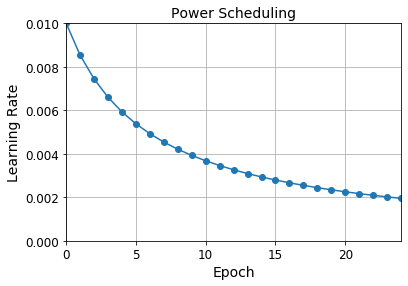

In [86]:
learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = len(X_train) // batch_size
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Exponential Scheduling
$$
\eta = \eta_0 \cdot 0.1^{\frac{t}{s}}
$$
The learning rate will gradually drop by a factor of 10 every $s$ steps. While power scheduling reduces the learning rate more and more slowly, exponential scheduling keeps slashing it by a factor of 10 every $s$ steps.

In [87]:
# here we set n0 = 0.01, s = 20 as a default
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

If you do not want to hard-code $\eta_0$ and $s$, you can create a function that returns a configured function:

In [88]:
# wrapper function for `exponential_decay_fn()
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [89]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer="nadam", metrics=["accuracy"])


In [90]:
# note that we use LearningRateScheduler()
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
n_epochs = 25

history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 7s 124us/sample - loss: 0.8791 - accuracy: 0.7481 - val_loss: 0.8047 - val_accuracy: 0.7612
Epoch 2/25
55000/55000 [==============================] - 6s 107us/sample - loss: 0.7890 - accuracy: 0.7654 - val_loss: 0.7888 - val_accuracy: 0.7766
Epoch 3/25
55000/55000 [==============================] - 6s 108us/sample - loss: 0.6607 - accuracy: 0.8023 - val_loss: 0.6255 - val_accuracy: 0.8314
Epoch 4/25
55000/55000 [==============================] - 6s 108us/sample - loss: 0.5977 - accuracy: 0.8262 - val_loss: 0.5678 - val_accuracy: 0.8278
Epoch 5/25
55000/55000 [==============================] - 6s 110us/sample - loss: 0.5283 - accuracy: 0.8465 - val_loss: 0.5615 - val_accuracy: 0.8504
Epoch 6/25
55000/55000 [==============================] - 6s 113us/sample - loss: 0.4725 - accuracy: 0.8591 - val_loss: 0.5955 - val_accuracy: 0.8574
Epoch 7/25
55000/55000 [===========================

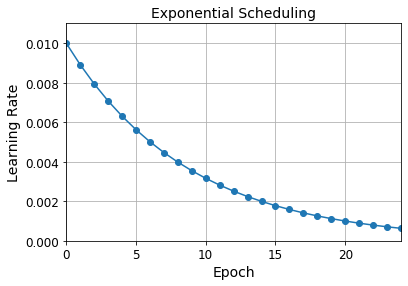

In [91]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

The schedule function can take the current learning rate as a second argument:

In [92]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1**(epoch / 20)

You can use `tf.keras` scheduler:
```python
s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer = keras.optimizers.SGD(learning_rate)
```

If you want to update the learning rate at each iteration rather than at each epoch, you must __write your own callback__ class:

In [93]:
K = keras.backend
###
class ExponentialDecay(keras.callbacks.Callback):
    def __init__(self, s=40000):
        super().__init__()
        self.s = s

    def on_batch_begin(self, batch, logs=None):
        # Note: the `batch` argument is reset at each epoch
        lr = K.get_value(self.model.optimizer.lr)
        K.set_value(self.model.optimizer.lr, lr * 0.1**(1 / s))

    def on_epoch_end(self, epoch, logs=None):
        # log learning rate at the end of each epoch
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)
###
        
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])

lr0 = 0.01
optimizer = keras.optimizers.Nadam(lr=lr0)

model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25

s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
exp_decay = ExponentialDecay(s) #####
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[exp_decay])

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 9s 158us/sample - loss: 0.8203 - accuracy: 0.7638 - val_loss: 0.6589 - val_accuracy: 0.7478
Epoch 2/25
55000/55000 [==============================] - 8s 140us/sample - loss: 0.6001 - accuracy: 0.8137 - val_loss: 0.6194 - val_accuracy: 0.8252
Epoch 3/25
55000/55000 [==============================] - 8s 136us/sample - loss: 0.6239 - accuracy: 0.8127 - val_loss: 0.5372 - val_accuracy: 0.8466
Epoch 4/25
55000/55000 [==============================] - 8s 142us/sample - loss: 0.4856 - accuracy: 0.8479 - val_loss: 0.5099 - val_accuracy: 0.8584
Epoch 5/25
55000/55000 [==============================] - 8s 143us/sample - loss: 0.4700 - accuracy: 0.8540 - val_loss: 0.5246 - val_accuracy: 0.8640
Epoch 6/25
55000/55000 [==============================] - 7s 134us/sample - loss: 0.4119 - accuracy: 0.8694 - val_loss: 0.5124 - val_accuracy: 0.8432
Epoch 7/25
55000/55000 [===========================

In [94]:
n_steps = n_epochs * len(X_train) // 32
steps = np.arange(n_steps)
lrs = lr0 * 0.1**(steps / s)

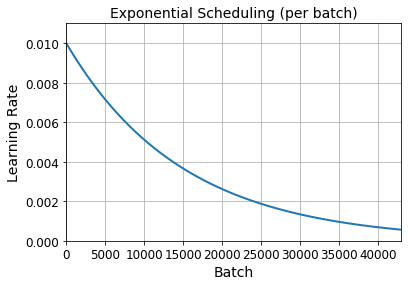

In [95]:
plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()

### Piecewise Constant Scheduling

In [96]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [97]:
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [98]:
# lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 8s 146us/sample - loss: 0.8467 - accuracy: 0.7548 - val_loss: 0.6916 - val_accuracy: 0.7870
Epoch 2/25
55000/55000 [==============================] - 7s 127us/sample - loss: 0.6678 - accuracy: 0.7986 - val_loss: 0.7247 - val_accuracy: 0.7836
Epoch 3/25
55000/55000 [==============================] - 7s 132us/sample - loss: 0.6179 - accuracy: 0.8240 - val_loss: 0.6268 - val_accuracy: 0.8378
Epoch 4/25
55000/55000 [==============================] - 7s 129us/sample - loss: 0.5431 - accuracy: 0.8440 - val_loss: 0.4637 - val_accuracy: 0.8696
Epoch 5/25
55000/55000 [==============================] - 8s 145us/sample - loss: 0.4837 - accuracy: 0.8574 - val_loss: 0.5194 - val_accuracy: 0.8572
Epoch 6/25
55000/55000 [==============================] - 7s 136us/sample - loss: 0.4687 - accuracy: 0.8649 - val_loss: 0.4555 - val_accuracy: 0.8702
Epoch 7/25
55000/55000 [===========================

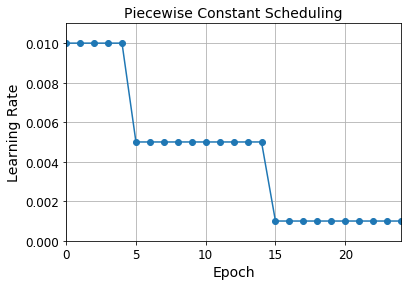

In [99]:
plt.plot(history.epoch, [piecewise_constant_fn(epoch) for epoch in history.epoch], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

To use `tf.keras` scheduler try this:
```python
learning_rate = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[5. * n_steps_per_epoch, 15. * n_steps_per_epoch],
    values=[0.01, 0.005, 0.001])
```

### Performance Scheduling
Measure the validation error every $N$ steps (just like for early stopping) and reduce the learning rate by a factor of $\lambda$ when the error stops dropping.

In [100]:
tf.random.set_seed(42)
np.random.seed(42)

Simply use the `ReduceLROnPlateau` callback. For exam‐ ple, if you pass the following callback to the fit() method, it will multiply the learning rate by 0.5 whenever the best validation loss does not improve for 5 consecutive epochs 

In [101]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(lr=0.02, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 4s 71us/sample - loss: 0.6036 - accuracy: 0.8052 - val_loss: 0.5546 - val_accuracy: 0.8126
Epoch 2/25
55000/55000 [==============================] - 3s 58us/sample - loss: 0.5147 - accuracy: 0.8370 - val_loss: 0.5252 - val_accuracy: 0.8346
Epoch 3/25
55000/55000 [==============================] - 3s 63us/sample - loss: 0.5197 - accuracy: 0.8430 - val_loss: 0.4358 - val_accuracy: 0.8590
Epoch 4/25
55000/55000 [==============================] - 4s 69us/sample - loss: 0.5022 - accuracy: 0.8494 - val_loss: 0.5276 - val_accuracy: 0.8514
Epoch 5/25
55000/55000 [==============================] - 3s 61us/sample - loss: 0.5252 - accuracy: 0.8486 - val_loss: 0.5415 - val_accuracy: 0.8492
Epoch 6/25
55000/55000 [==============================] - 3s 63us/sample - loss: 0.4994 - accuracy: 0.8563 - val_loss: 0.7048 - val_accuracy: 0.8370
Epoch 7/25
55000/55000 [==============================] -

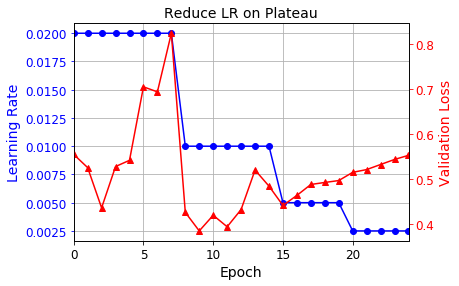

In [102]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

### 1Cycle scheduling

Contrary to the other approaches, **1cycle** starts by increasing the initial learning rate $\eta_0$, growing linearly up to $\eta_1$ halfway through training. Then it decreases the learning rate linearly down to $\eta_0$ again during the second half of training, finishing the last few epochs by dropping the rate down by several orders of magnitude (still linearly). The maximum learning rate $\eta_1$ is chosen using the same approach we used to find the optimal learning rate, and the initial learning rate $\eta_0$ is chosen to be roughly 10 times lower. When usingn a momentum, we start with a high momentum first (e.g., 0.95), then drop it down to a lower momentum during the first half of training (e.g., down to 0.85, linearly), and then bring it back up to the maximum value (e.g., 0.95) during the second half of training, finishing the last few epochs with that maximum value. The author of the paper, Leslie Smith, did many experiments showing that this approach was often able to speed up training considerably and reach better performance. 

> reference [this paper](https://arxiv.org/abs/1803.09820)

**First let's find $\eta_1$ for exponential learning rate**

In [103]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = list()
        self.losses = list()
    def on_batch_end(self, batch, logs): # drop lr by the factor
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

def find_learning_rate(model, X, y, epochs=1, 
                       batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights() # to protect initial weight
    iterations = len(X) // batch_size * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr) # protect initial lr
    ## finding best lr start
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)  
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    ## put it back to the initial status
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    ## return values for analysis 
    return exp_lr.rates, exp_lr.losses
 
def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

In [104]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

Train on 55000 samples
55000/55000 [==============================] - 2s 36us/sample - loss: nan - accuracy: 0.3888


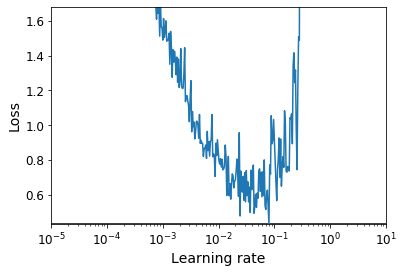

In [105]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, 
                                   epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

> ### Reference for _interpolate( )
first half (uphill):
$$
\eta_0 + \frac{\eta_1 - \eta_0}{half - start} \times (current - start)
$$
Second half (downhill):
$$
\eta_1 + \frac{\eta_0 - \eta_1}{end - half} \times (current - half)
$$
last epochs (fine-tunning):
$$
\eta_0 + \frac{\text{last_rate} - \eta_0}{\text{total_iteration} - end} \times (current - end)
$$


In [106]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations # set iteration number
        self.max_rate = max_rate # η1 we found 
        self.start_rate = start_rate or max_rate / 10 # η0
        self.last_iterations = last_iterations or iterations // 10 + 1 # last iterations for fine-tuning
                                                                       # ~10%
        self.half_iteration = (iterations - self.last_iterations) // 2 # half iteration cycle
                                                                       # ~45%
        self.last_rate = last_rate or self.start_rate / 1000 # set fine-tuning learnign rate
        self.iteration = 0 # current iteration count    
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration-iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration: # first half 
            rate = self._interpolate(iter1 = 0, 
                                     iter2 = self.half_iteration, 
                                     rate1 = self.start_rate, 
                                     rate2 = self.max_rate)
        elif self.iteration < 2 * self.half_iteration: # second half
            rate = self._interpolate(iter1 = self.half_iteration, 
                                     iter2 = 2 * self.half_iteration,
                                     rate1 = self.max_rate, 
                                     rate2 = self.start_rate)
        else: # last epochs
            rate = self._interpolate(iter1 = 2 * self.half_iteration, 
                                     iter2 = self.iterations,
                                     rate1 = self.start_rate, 
                                     rate2 = self.last_rate)
            rate = max(rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate) # set learning rate    
    def on_epoch_end(self, epoch, logs=None):
        # log learning rate at the end of each epoch
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

In [107]:
n_epochs = 25
K.clear_session()

onecycle = OneCycleScheduler(iterations = len(X_train) // batch_size * n_epochs, 
                             max_rate = 0.05) # η1

history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 2s 34us/sample - loss: 0.6569 - accuracy: 0.7750 - val_loss: 0.4875 - val_accuracy: 0.8300
Epoch 2/25
55000/55000 [==============================] - 2s 32us/sample - loss: 0.4584 - accuracy: 0.8391 - val_loss: 0.4390 - val_accuracy: 0.8476
Epoch 3/25
55000/55000 [==============================] - 2s 34us/sample - loss: 0.4124 - accuracy: 0.8541 - val_loss: 0.4102 - val_accuracy: 0.8570
Epoch 4/25
55000/55000 [==============================] - 2s 32us/sample - loss: 0.3842 - accuracy: 0.8643 - val_loss: 0.3893 - val_accuracy: 0.8652
Epoch 5/25
55000/55000 [==============================] - 2s 32us/sample - loss: 0.3641 - accuracy: 0.8707 - val_loss: 0.3736 - val_accuracy: 0.8678
Epoch 6/25
55000/55000 [==============================] - 2s 33us/sample - loss: 0.3456 - accuracy: 0.8781 - val_loss: 0.3652 - val_accuracy: 0.8726
Epoch 7/25
55000/55000 [==============================] -

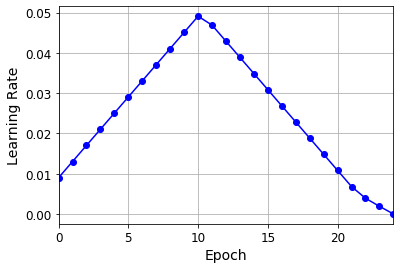

In [108]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.gca().set_xlim(0, n_epochs-1)
plt.grid(True)

# Avoiding Overfitting Through Regularization

## $\ell_1$ and $\ell_2$ regularization

In [109]:
layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01)) # here l2
# or l1(0.1) for ℓ1 regularization with a factor or 0.1
# or l1_l2(0.1, 0.01) for both ℓ1 and ℓ2 regularization, with factors 0.1 and 0.01 respectively

In [110]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)), #
    keras.layers.Dense(100, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)), #
    keras.layers.Dense(10, activation="softmax",
                       kernel_regularizer=keras.regularizers.l2(0.01)) #
])
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/2
55000/55000 [==============================] - 9s 171us/sample - loss: 1.5895 - accuracy: 0.8103 - val_loss: 0.7553 - val_accuracy: 0.8096
Epoch 2/2
55000/55000 [==============================] - 9s 161us/sample - loss: 0.7184 - accuracy: 0.8264 - val_loss: 0.7178 - val_accuracy: 0.8222


Since you will typically want to apply the same regularizer to all layers in your network, as well as the same activation function and the same initialization strategy in all hidden layers, you may find yourself repeating the same arguments over and over. This makes it ugly and error-prone. To avoid this, you can try refactoring your code to use loops. Another option is to use Python’s `functools.partial()` function: it lets you create a thin wrapper for any callable, with some default argument values. 

In [111]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300), #
    RegularizedDense(100), #
    RegularizedDense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/2
55000/55000 [==============================] - 8s 150us/sample - loss: 1.6418 - accuracy: 0.8107 - val_loss: 0.7600 - val_accuracy: 0.8068
Epoch 2/2
55000/55000 [==============================] - 8s 140us/sample - loss: 0.7197 - accuracy: 0.8262 - val_loss: 0.7175 - val_accuracy: 0.8254


## Dropout

It is a fairly simple algorithm: at every training step, every neuron (including the input neurons, but always excluding the output neurons) has a probability $p$ of being temporarily “dropped out,” meaning it will be entirely ignored during this training step, but it may be active during the next step. The hyperparameter $p$ is called the dropout rate, and it is typically set to between 10% and 50%: closer to 20-30% in recurrent neural nets, and closer to 40-50% in convolutional nerual networks. After training, neurons don’t get dropped anymore. 

![Figure 11-9](https://github.com/soo-pecialist/Hands_on_ML_w_Scikit_Karas_and_TensorFlow/blob/master/images_used/figure11-9.png?raw=true)

In [112]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/2
55000/55000 [==============================] - 9s 156us/sample - loss: 0.5765 - accuracy: 0.8004 - val_loss: 0.3741 - val_accuracy: 0.8642
Epoch 2/2
55000/55000 [==============================] - 8s 149us/sample - loss: 0.4243 - accuracy: 0.8441 - val_loss: 0.3647 - val_accuracy: 0.8612


> Since dropout is only active during training, the training loss is penalized compared to the validation loss, so comparing the two can be misleading. In particular, a model may be overfitting the training set and yet have similar training and validation losses. So make sure to evaluate the training loss without dropout (e.g., after training). Alternatively, you can call the `fit()` method inside a `with keras.backend.learning_phase_scope(1)` block: this will force dropout to be active during both training and validation.

In [113]:
K.clear_session()

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2

## note here
with keras.backend.learning_phase_scope(1):
    history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                        validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/2
55000/55000 [==============================] - 10s 174us/sample - loss: 0.5731 - accuracy: 0.8027 - val_loss: 0.3649 - val_accuracy: 0.8690
Epoch 2/2
55000/55000 [==============================] - 9s 159us/sample - loss: 0.4217 - accuracy: 0.8454 - val_loss: 0.3543 - val_accuracy: 0.8606


It seems slightly underfitting! Let us lower the dropout rate by a bit.

In [114]:
K.clear_session()

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.1),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.1),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.1),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2

## note here
with keras.backend.learning_phase_scope(1):
    history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                        validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/2
55000/55000 [==============================] - 9s 157us/sample - loss: 0.5042 - accuracy: 0.8231 - val_loss: 0.3639 - val_accuracy: 0.8682
Epoch 2/2
55000/55000 [==============================] - 8s 150us/sample - loss: 0.3705 - accuracy: 0.8628 - val_loss: 0.3617 - val_accuracy: 0.8682


Better!

> If you observe that the model is overfitting, you can increase the dropout rate. Conversely, you should try decreasing the dropout rate if the model underfits the training set. It can also help to increase the dropout rate for large layers, and reduce it for small ones. Moreover, many state-of-the-art architectures only use dropout after the last hidden layer, so you may want to try this if full dropout is too strong.

## Alpha Dropout

> If you want to regularize a __self-normalizing__ network based on the `SELU activation` function, you should use` AlphaDropou`: this is a variant of dropout that __preserves the mean and standard deviation of its inputs__

In [115]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.AlphaDropout(rate=0.1),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.1),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.1),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=optimizer, metrics=["accuracy"])

n_epochs = 20
with keras.backend.learning_phase_scope(1):
    history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                        validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 5s 90us/sample - loss: 0.5709 - accuracy: 0.7967 - val_loss: 0.4790 - val_accuracy: 0.8500
Epoch 2/20
55000/55000 [==============================] - 4s 81us/sample - loss: 0.4723 - accuracy: 0.8270 - val_loss: 0.4284 - val_accuracy: 0.8548
Epoch 3/20
55000/55000 [==============================] - 4s 70us/sample - loss: 0.4371 - accuracy: 0.8383 - val_loss: 0.4084 - val_accuracy: 0.8668
Epoch 4/20
55000/55000 [==============================] - 4s 71us/sample - loss: 0.4183 - accuracy: 0.8451 - val_loss: 0.4004 - val_accuracy: 0.8694
Epoch 5/20
55000/55000 [==============================] - 4s 69us/sample - loss: 0.4083 - accuracy: 0.8500 - val_loss: 0.3763 - val_accuracy: 0.8754
Epoch 6/20
55000/55000 [==============================] - 4s 68us/sample - loss: 0.3924 - accuracy: 0.8531 - val_loss: 0.3872 - val_accuracy: 0.8754
Epoch 7/20
55000/55000 [==============================] -

In [116]:
model.evaluate(X_test_scaled, y_test, verbose=0)

[0.39705089289546014, 0.8758]

In [117]:
model.evaluate(X_train_scaled, y_train, verbose=0)

[0.24811554857600818, 0.9076]

In [118]:
history = model.fit(X_train_scaled, y_train)

Train on 55000 samples
55000/55000 [==============================] - 4s 66us/sample - loss: 0.3300 - accuracy: 0.8772


## Monte-Carlo (MC) Dropout
In 2016, a paper by Yarin Gal and Zoubin Ghahramani added more good reasons to use dropout:
- First, the paper establishes a profound connection between dropout networks (i.e., neural networks containing a dropout layer before every weight layer) and approximate Bayesian inference, giving dropout a solid mathematical justification.
- Second, they introduce a powerful technique called MC Dropout, which can boost the performance of any trained dropout model, without having to retrain it or even modify it at all!
- Moreover, MC Dropout also provides a much better measure of the model’s uncertainty.
- Finally, it is also amazingly simple to implement. If this all sounds like a “one weird trick” advertisement, then take a look at the following code. It is the full implementation of MC Dropout, boosting the dropout model we trained earlier, without retraining it:


In [119]:
tf.random.set_seed(42)
np.random.seed(42)

In [120]:
with keras.backend.learning_phase_scope(1): # force training mode = dropout on
    y_probas = np.stack([model(X_test_scaled, training=True) 
                                     for sample in range(100)])
y_proba = y_probas.mean(axis=0)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [121]:
model(X_test_scaled, training=True).shape

TensorShape([10000, 10])

In [122]:
X_test_scaled.shape

(10000, 28, 28)

In [123]:
y_probas.shape

(100, 10000, 10)

In [124]:
model.predict(X_test_scaled[:1])

array([[4.4878369e-19, 1.6336389e-15, 5.4883834e-20, 1.1254964e-16,
        1.8374606e-19, 6.4339079e-06, 3.4016291e-22, 1.0996811e-03,
        1.0160490e-16, 9.9889392e-01]], dtype=float32)

In [125]:
np.round(model.predict(X_test_scaled[:1]), 2)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [126]:
np.round(y_probas[:, :1], 2).shape

(100, 1, 10)

In [127]:
y_proba.shape

(10000, 10)

In [128]:
np.round(y_proba[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.09, 0.  , 0.9 ]],
      dtype=float32)

In [129]:
y_std = y_probas.std(axis=0)
np.round(y_std[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.04, 0.  , 0.15, 0.  , 0.16]],
      dtype=float32)

In [130]:
y_pred = np.argmax(y_proba, axis=1)

In [131]:
accuracy = np.sum(y_pred == y_test) / len(y_test)
accuracy

0.8775

> The number of Monte Carlo samples you use (100 in this example) is a hyperparameter you can tweak. The higher it is, the more accurate the predictions and their uncertainty estimates will be.

If your model contains other layers that behave in a special way during training (such as Batch Normalization layers), then you __should not force training mode__ like we just did. Instead, you should __replace the Dropout layers with the following__ `MCDropout` class:

In [132]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True) # only force training on dropout layer

class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [133]:
tf.random.set_seed(42)
np.random.seed(42)

In [134]:
# copy layers
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) 
    if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

In [135]:
mc_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
mc_alpha_dropout (MCAlphaDro (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 300)               235500    
_________________________________________________________________
mc_alpha_dropout_1 (MCAlphaD (None, 300)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               30100     
_________________________________________________________________
mc_alpha_dropout_2 (MCAlphaD (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)               

In [136]:
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
mc_model.compile(loss="sparse_categorical_crossentropy", 
                 optimizer=optimizer, metrics=["accuracy"])

In [137]:
# copy weights
mc_model.set_weights(model.get_weights())

Now we can use the model with MC Dropout:

In [138]:
np.round(np.mean(
    [mc_model.predict(X_test_scaled[:1]) for sample in range(100)], 
                axis=0), 
         2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.1 , 0.  , 0.88]],
      dtype=float32)

## Max norm
Max-norm regularization does not add a regularization loss term to the overall loss function. Instead, it is typically implemented by computing $\lVert w \rVert_2$ after each training
step and clipping $w$ if needed ($w \leftarrow w\frac{r}{\lVert w \rVert_2}$)
Reducing $r$ increases the amount of regularization and helps reduce overfitting. Max-norm regularization can also help alleviate the vanishing/exploding gradients problems (if you are not using Batch Normalization). Here $r$ is the max-norm hyperparameter.

In [139]:
layer = keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal",
                           kernel_constraint=keras.constraints.max_norm(1.))

In [140]:
MaxNormDense = partial(keras.layers.Dense,
                       activation="selu", kernel_initializer="lecun_normal",
                       kernel_constraint=keras.constraints.max_norm(1.))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(300),
    MaxNormDense(100),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/2
55000/55000 [==============================] - 10s 182us/sample - loss: 0.4762 - accuracy: 0.8327 - val_loss: 0.3840 - val_accuracy: 0.8648
Epoch 2/2
55000/55000 [==============================] - 9s 161us/sample - loss: 0.3597 - accuracy: 0.8685 - val_loss: 0.3604 - val_accuracy: 0.8682


# Summary

We have covered a wide range of techniques and you may be wondering which ones you should use. The configuration in the [table 11-3](#summary) below will work fine in most cases, without requiring much hyperparameter tuning.

<img src="https://github.com/soo-pecialist/Hands_on_ML_w_Scikit_Karas_and_TensorFlow/blob/master/images_used/table11-3.jpg?raw=true" width=500>

If the network is a simple stack of dense layers, then it can self-normalize, and you should use the configuration in [Table 11-4](#summary) instead.

<img src="https://github.com/soo-pecialist/Hands_on_ML_w_Scikit_Karas_and_TensorFlow/blob/master/images_used/table11-4.jpg?raw=true" width=500>

The default configuration may need to be tweaked:
- If your model **self-normalizes**:
    * If it overfits the training set, then you should add alpha dropout (and always use early stopping as well). Do not use other regularization methods, or else they would break self-normalization.
- If your model **cannot self-normalize** (e.g., it is a recurrent net or it contains skip connections):
    * You can try using `ELU` (or another activation function) instead of SELU, it may perform better. Make sure to change the initialization method accordingly (e.g., `He` init for `ELU` or `ReLU`).
    * If it is a deep network, you should use Batch Normalization after every hidden layer. If it overfits the training set, you can also try using max-norm or $\ell2$ regularization.
- If you need a sparse model, you can use $\ell1$ regularization (and optionally zero out the tiny weights after training). If you need an even sparser model, you can try using `FTRL` instead of `Nadam` optimization, along with $\ell1$ regularization. In any case, this will break self-normalization, so you will need to switch to `BN` if your model is deep.
- If you need a low-latency model (one that performs lightning-fast predictions), you may need to use less layers, avoid Batch Normalization, and possibly replace the `SELU` activation function with the leaky ReLU. Having a sparse model will also help. You may also want to reduce the float precision from 32-bits to 16-bit (or even 8-bits).
- If you are building a risk-sensitive application, or inference latency is not very important in your application, you can use `MC Dropout` to boost performance and get more reliable probability estimates, along with uncertainty estimates.